This notebook shows how to use mixture density networks in pytorch environments.
Mixture density networks are to learn probablistic functions, Gaussian mixture models, from data.
Some data often have one-to-many mappings, which means that one sample possibly has multiple ground truths.
For example, one desired pair of coordinates (x_0) of a robotic arm can have multiple combinations (y_0, y_1..) of angles to achieve it.
https://www.mathworks.com/help/fuzzy/examples/modeling-inverse-kinematics-in-a-robotic-arm.html

Conventional supervised learning focuses on one-to-one mappings and does not work with this situation in an efficient way. To overcome this, several interesting approaches have been proposed, and one of them is mixture density neural networks (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.120.5685&rep=rep1&type=pdf).

Mixture density neural networks learn relations between input feature vectors and parameters(mixture of co-efficients, mean, variance. Using these predicted parameters, we can generate samples.

Tutorials can be found in: https://pdfs.semanticscholar.org/presentation/dc0f/89a81b0c21904ca72d7e35a0117c8f7db3a7.pdf

In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch.nn as nn
import torch
import torch.optim as optim
import mdn
import numpy as np
import IPython

from torch.autograd import Variable
from scipy import stats
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [22]:
def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    return train_test_split(x_data, y_data, random_state=42)

def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all
    components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        
    if comp:
        ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)
    

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    print("mixture num: ", n_mix)
    
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
        zip(pred_weights, pred_means, pred_std)):
        #choose mixture in a random way
        index = np.random.choice(to_choose_from, p=weights)
        #Draw random samples from a normal (Gaussian) distribution.
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

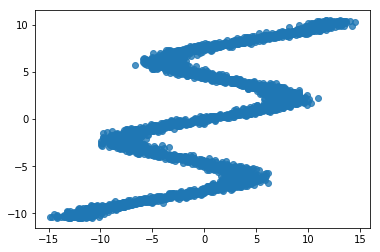

In [20]:
#data generation
N = 5000
in_feat = 1
h_size = 40
out_feat = 1
n_component = 20
n_epoch = 300
batch_size = 50

X_train, X_test, Y_train, Y_test = build_toy_dataset(N)

sns.regplot(X_train, Y_train, fit_reg=False)
plt.show()



In [4]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

X_train = X_train.view(-1, batch_size, in_feat)
Y_train = Y_train.view(-1, batch_size, in_feat)

X_test = X_test.view(-1, batch_size, in_feat)
Y_test = Y_test.view(-1, batch_size, in_feat)

print("X, Y train: ", X_train.size(), Y_train.size())
print("X, Y test: ", X_test.size(), Y_test.size())


X, Y train:  torch.Size([75, 50, 1]) torch.Size([75, 50, 1])
X, Y test:  torch.Size([25, 50, 1]) torch.Size([25, 50, 1])


In [5]:
# initialize the model
model = nn.Sequential(
    nn.Linear(in_feat, h_size),
    nn.Tanh(),
    nn.Linear(h_size, h_size),
    nn.Tanh(),        
    mdn.MDN(h_size, out_feat, n_component)
)

optimizer = optim.Adam(model.parameters(), lr= 0.005)


In [6]:
#training
device = torch.device("cuda")
model.to(device)

loss_history = {"train": [], "test": []}

for epoch in range(0, n_epoch):
    
    if epoch % 100 == 0:
        print("epoch: ", epoch)
    
    model.train()
    t_loss = 0.0
    #fitting
    for minibatch, labels in zip(X_train, Y_train):        
        
        
        minibatch = Variable(minibatch.to(device)).float()
        labels = Variable(labels.to(device)).float()
        model.zero_grad()
        pi, sigma, mu = model(minibatch)        
        loss = mdn.mdn_loss(pi, sigma, mu, labels)
        
        loss.backward()
        optimizer.step()
        t_loss += loss.data[0]    
    
    t_loss = t_loss / (X_train.size(0) * X_train.size(1))
    loss_history["train"].append(t_loss)    
    
    #validation
    model.eval()
    minibatch = Variable(X_test[0].to(device)).float()
    labels = Variable(Y_test[0].to(device)).float()
    model.zero_grad()
    pi, sigma, mu = model(minibatch)
    loss = mdn.mdn_loss(pi, sigma, mu, labels)
    e_loss = loss.data[0] / batch_size
    loss_history["test"].append(e_loss)
    

print("done")

epoch:  0


/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.5/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
done


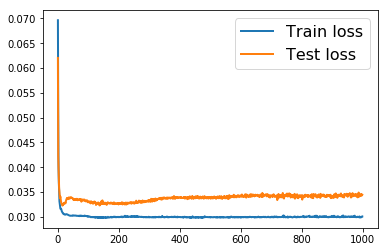

In [7]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

/home/jaebok/miniconda3/envs/pytorch_env/lib/python3.5/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


X:  torch.Size([1250, 1])
ground truth Y:  torch.Size([1250, 1])
pi, sigma, mu:  torch.Size([1250, 20]) torch.Size([1250, 20, 1]) torch.Size([1250, 20, 1])


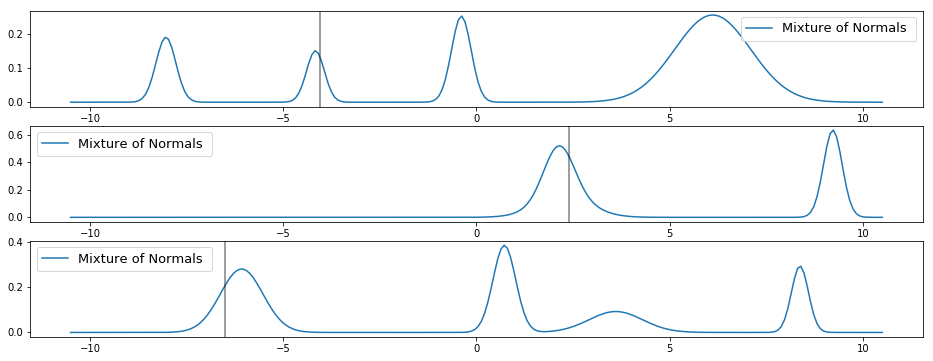

In [14]:
# sampleing new points from the trained model

#let's use the entire test set
X, Y = X_test.view(-1, 1).to(device), Y_test.view(-1, 1).to(device)
#first predict parameters from MDN
pi, sigma, mu = model(Variable(X).float())

print("X: ", X.size())
print("ground truth Y: ", Y.size())
print("pi, sigma, mu: ", pi.size(), sigma.size(), mu.size())

#cuda can't be numpy, only cpu torch can be.
pi = pi.to("cpu").detach().numpy()
sigma = sigma.to("cpu").detach().numpy()
mu = mu.to("cpu").detach().numpy()

obj = [10, 15, 20]# draw three inputs' PDF among all test set.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6))

plot_normal_mix(pi[obj][0], mu[obj][0],
                sigma[obj][0], axes[0], comp=False)
axes[0].axvline(x=Y[obj][0], color='black', alpha=0.5)

plot_normal_mix(pi[obj][1], mu[obj][1],
                sigma[obj][1], axes[1], comp=False)
axes[1].axvline(x=Y[obj][1], color='black', alpha=0.5)

plot_normal_mix(pi[obj][2], mu[obj][2],
                sigma[obj][2], axes[2], comp=False)
axes[2].axvline(x=Y[obj][2], color='black', alpha=0.5)
plt.show()

mixture num:  20


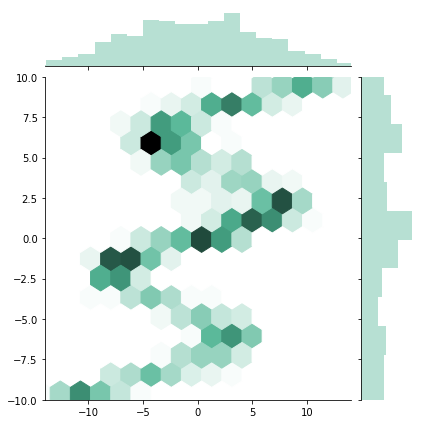

In [23]:
#draw samples from mixture 
a = sample_from_mixture(X, pi, mu,
                        sigma, amount=len(X))

#plot X and Y sampled from mixtures
sns.jointplot(a[:, 0], a[:, 1], kind="hex", color="#4CB391",
              ylim=(-10, 10), xlim=(-14, 14))
plt.show()
